In [1]:
import pandas as pd
import numpy as np

In [ ]:
df = pd.read_parquet('cleared_dataset.pqt')
df

In [3]:
def target_constructor(df, id_product):
    """
    Разделяет данные для конкретного product_id на Train (прошлые месяцы) и OOT (последний месяц).
    """

    # Фильтруем датасет по нужному продукту
    df_prod = df[df['product_id'] == id_product].copy()
    
    # Проверка: если данных по продукту нет
    if df_prod.empty:
        print(f"Ошибка: Продукт {id_product} не найден в датасете.")
        return None, None, None, None

    # Убеждаемся, что timestamp — это дата
    df_prod['timestamp'] = pd.to_datetime(df_prod['timestamp'])
    
    # Создаем вспомогательную колонку 'period' (год-месяц) для удобного поиска последнего месяца
    df_prod['period'] = df_prod['timestamp'].dt.to_period('M')
    
    # Находим последний месяц (максимальный период)
    last_period = df_prod['period'].max()
    
    # Разделяем на Train (всё кроме последнего) и OOT (только последний)
    mask_oot = df_prod['period'] == last_period
    
    df_train_full = df_prod[~mask_oot] # Все прошлые месяцы
    df_oot_full = df_prod[mask_oot]    # Последний месяц
    
    # Формируем X и y
    # X - удаляем таргет (и вспомогательную колонку period)
    # y - только таргет
    x_train = df_train_full.drop(columns=['is_sold', 'period'])
    y_train = df_train_full['is_sold']
    
    x_oot = df_oot_full.drop(columns=['is_sold', 'period'])
    y_oot = df_oot_full['is_sold']
    
    # --- БЛОК ВЫВОДА ИНФОРМАЦИИ (PRINT) ---
    print("="*60)
    print(f"СТАТИСТИКА ПО ПРОДУКТУ: {id_product}")
    print("="*60)
    
    # Размеры выборок
    print(f"Размер x_train: {x_train.shape[0]} строк")
    print(f"Размер y_train: {y_train.shape[0]} строк")
    print(f"Размер x_oot:   {x_oot.shape[0]} строк")
    print(f"Размер y_oot:   {y_oot.shape[0]} строк")
    print("-" * 30)
    
    # Информация о периодах
    # Берем последний месяц из трейна (если трейн не пустой)
    if not df_train_full.empty:
        max_train_date = df_train_full['timestamp'].max()
        print(f"Последний месяц в TRAIN: {max_train_date.strftime('%B %Y')}")
    else:
        print("TRAIN пуст (возможно, у продукта данные только за 1 месяц)")

    # Месяц OOT
    print(f"Месяц OOT (Test):        {last_period.strftime('%B %Y')}")
    print("-" * 30)
    
    # Статистика по is_sold (конверсия) по месяцам
    print("Распределение is_sold (процент продаж) по месяцам:")
    
    # Объединяем обратно временно для красивого группирования, или используем исходный df_prod
    stats = df_prod.groupby('period')['is_sold'].agg(['count', 'mean'])
    stats['mean'] = (stats['mean'] * 100).round(2)
    stats.columns = ['Кол-во записей', 'Процент продаж %']
    
    # Помечаем, какая строка попала в OOT
    stats['Тип выборки'] = stats.index.map(lambda x: 'OOT' if x == last_period else 'TRAIN')
    
    print(stats)
    print("="*60 + "\n")

    return x_train, y_train, x_oot, y_oot

In [ ]:
x_train, y_train, x_oot, y_oot = target_constructor(df, 10)

СТАТИСТИКА ПО ПРОДУКТУ: 10
Размер x_train: 23325 строк
Размер y_train: 23325 строк
Размер x_oot:   1979 строк
Размер y_oot:   1979 строк
------------------------------
Последний месяц в TRAIN: March 2023
Месяц OOT (Test):        April 2023
------------------------------
Распределение is_sold (процент продаж) по месяцам:
         Кол-во записей  Процент продаж % Тип выборки
period                                               
2023-01           10361             21.22       TRAIN
2023-02           10788             23.20       TRAIN
2023-03            2176             51.56       TRAIN
2023-04            1979             75.75         OOT



In [5]:
from lightautoml.automl.presets.tabular_presets import TabularAutoML
from lightautoml.tasks import Task

'nlp' extra dependency package 'gensim' isn't installed. Look at README.md in repo 'LightAutoML' for installation instructions.
'nlp' extra dependency package 'gensim' isn't installed. Look at README.md in repo 'LightAutoML' for installation instructions.


Disabling PyTorch because PyTorch >= 2.2 is required but found 2.1.0+cu121
PyTorch was not found. Models won't be available and only tokenizers, configuration and file/data utilities can be used.
C:\Users\Mukharyam\AppData\Local\Programs\Python\Python311\Lib\site-packages\lightautoml\transformers\text.py:22: UserWarning: 'gensim' - package isn't installed
  warnings.warn("'gensim' - package isn't installed")


In [6]:
target_col = 'is_sold' 

# Если y_train это Series, убедимся, что у неё есть имя
if isinstance(y_train, pd.Series):
    y_train.name = target_col

# Склеиваем X_train и y_train
train_data = pd.concat([x_train, y_train], axis=1)

In [7]:
cols_to_drop = ['user_id', 'product_id', 'timestamp', 'period']
# Оставляем только те, что реально есть в датасете
cols_to_drop = [c for c in cols_to_drop if c in train_data.columns]

roles = {
    'target': target_col,     # Имя колонки с таргетом
    'drop': cols_to_drop      # Список колонок для удаления
}

In [ ]:
# Определяем задачу: бинарная классификация, метрика AUC
task = Task(name='binary', metric='auc')

print("Запускаем LightAutoML...")

# Инициализируем AutoML
# timeout - сколько секунд даем на обучение (например, 3600 = 1 час). 
# Чем больше времени, тем лучше модель.
# cpu_limit - сколько ядер использовать (-1 = все).
# gpu_ids='0' - если есть видеокарта, LAMA ускорит обучение линейных моделей и CatBoost.
automl = TabularAutoML(
    task=task, 
    timeout=3600 * 3,   # 3 часа — отлично для тюнинга
    cpu_limit=-1,
    gpu_ids='0',        # GPU работает на полную
    
    reader_params={
        'n_jobs': 1,        # Оставляем 1, чтобы не падало по памяти
        'cv': 5,            # 5 фолдов — золотой стандарт
        'random_state': 42
    },
    
    # === ГЛАВНЫЕ ИЗМЕНЕНИЯ ЗДЕСЬ ===
    general_params={
        # Мы строим 2-уровневую архитектуру (Stacking):
        'use_algos': [
            # УРОВЕНЬ 1: "Тяжелая артиллерия"
            # linear_l2 - ловит линейные тренды
            # lgb_tuned - LightGBM с подбором параметров
            # cb_tuned  - CatBoost с подбором параметров
            ['linear_l2', 'lgb_tuned', 'cb_tuned'], 
            
            # УРОВЕНЬ 2: "Мета-модель" (принимает ответы от уровня 1)
            # Обычно берем простую линейную модель или легкий бустинг
            # Они учатся, кому из моделей 1-го уровня верить больше
            ['linear_l2', 'cb']
        ]
    },
    
    # Настройки самого процесса тюнинга (подбора параметров)
    tuning_params={
        'max_tuning_iter': 100,      # Попробовать 100 разных комбинаций параметров
        'max_tuning_time': 3600,     # Тратить до 1 часа чисто на перебор параметров
        'fit_on_holdout': True       # Тюниться на отложенной выборке (быстрее)
    }
)

# Обучаем (fit_predict сразу вернет предсказания на OOF (Out-of-Fold) фолдах трейна)
oof_pred = automl.fit_predict(train_data, roles=roles, verbose=1)

print(f"Модель обучена!\n")
print(automl.create_model_str_desc()) # Печатает красивое описание, какие модели вошли в ансамбль

🚀 Запускаем LightAutoML...
[00:01:31] Stdout logging level is INFO.
[00:01:31] Copying TaskTimer may affect the parent PipelineTimer, so copy will create new unlimited TaskTimer
[00:01:31] Task: binary

[00:01:31] Start automl preset with listed constraints:
[00:01:31] - time: 10800.00 seconds
[00:01:31] - CPU: 16 cores
[00:01:31] - memory: 16 GB

[00:01:31] Train data shape: (23325, 1294)

[00:02:44] Layer 1 train process start. Time left 10727.53 secs
[00:02:50] Start fitting Lvl_0_Pipe_0_Mod_0_LinearL2 ...
[00:03:13] Fitting Lvl_0_Pipe_0_Mod_0_LinearL2 finished. score = 0.7645370078146242
[00:03:13] Lvl_0_Pipe_0_Mod_0_LinearL2 fitting and predicting completed
[00:03:13] Time left 10698.88 secs

[00:04:37] Selector_LightGBM fitting and predicting completed
[00:04:41] Start hyperparameters optimization for Lvl_0_Pipe_1_Mod_0_Tuned_LightGBM ... Time budget is 2198.19 secs


Optimization Progress:  43%|██████████████████████████████████████▎                                                  | 43/100 [37:12<49:19, 51.92s/it, best_trial=37, best_value=0.799]

[00:41:54] Hyperparameters optimization for Lvl_0_Pipe_1_Mod_0_Tuned_LightGBM completed
[00:41:54] Start fitting Lvl_0_Pipe_1_Mod_0_Tuned_LightGBM ...


[00:43:41] Fitting Lvl_0_Pipe_1_Mod_0_Tuned_LightGBM finished. score = 0.7955304437862578
[00:43:41] Lvl_0_Pipe_1_Mod_0_Tuned_LightGBM fitting and predicting completed
[00:43:41] Start hyperparameters optimization for Lvl_0_Pipe_1_Mod_1_Tuned_CatBoost ... Time budget is 2817.09 secs


Optimization Progress: 100%|████████████████████████████████████████████████████████████████████████████████████████| 100/100 [34:25<00:00, 20.65s/it, best_trial=82, best_value=0.802]

[01:18:07] Hyperparameters optimization for Lvl_0_Pipe_1_Mod_1_Tuned_CatBoost completed
[01:18:07] Start fitting Lvl_0_Pipe_1_Mod_1_Tuned_CatBoost ...


[01:19:43] Fitting Lvl_0_Pipe_1_Mod_1_Tuned_CatBoost finished. score = 0.7960403538165166
[01:19:43] Lvl_0_Pipe_1_Mod_1_Tuned_CatBoost fitting and predicting completed
[01:19:43] Time left 6108.93 secs

[01:19:43] Layer 1 training completed.

[01:19:43] Layer 2 train process start. Time left 6108.20 secs
[01:19:49] Start fitting Lvl_1_Pipe_0_Mod_0_LinearL2 ...
[01:20:43] Fitting Lvl_1_Pipe_0_Mod_0_LinearL2 finished. score = 0.8694916952547767
[01:20:43] Lvl_1_Pipe_0_Mod_0_LinearL2 fitting and predicting completed
[01:20:43] Time left 6048.45 secs

[01:20:47] Start fitting Lvl_1_Pipe_1_Mod_0_CatBoost ...
[01:21:49] Fitting Lvl_1_Pipe_1_Mod_0_CatBoost finished. score = 0.7947154982038701
[01:21:49] Lvl_1_Pipe_1_Mod_0_CatBoost fitting and predicting completed
[01:21:49] Time left 5982.66 secs

[01:21:49] Layer 2 training completed.

[01:21:49] Blending: optimization starts with equal weights. Score = 0.8602794
[01:21:49] Blending: iteration 0: score = 0.8700514, weights = [0.9142074  0.08

In [ ]:
print("Делаем предсказание на OOT выборке...")

# predict возвращает специальный объект, нам нужно достать из него .data
test_predictions = automl.predict(x_oot)

# test_predictions.data — это numpy массив формы (N, 1) с вероятностями класса 1
y_pred = test_predictions.data[:, 0]

# --- ИТОГ ---
print("Предсказания готовы в переменной 'y_pred'.")
print(f"Размер предсказаний: {y_pred.shape}")
print(f"Примеры вероятностей: {y_pred[:5]}")

🔮 Делаем предсказание на OOT выборке...
Предсказания готовы в переменной 'y_pred'.
Размер предсказаний: (1979,)
Примеры вероятностей: [0.23867387 0.7663952  0.8469558  0.0421653  0.477885  ]


In [10]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import (
    roc_auc_score, 
    average_precision_score,
    roc_curve,
    precision_recall_curve
)

def metric_report(y_true, y_pred, ks=(1, 3, 5, 10, 20)):
    y_true = np.array(y_true)
    y_pred = np.array(y_pred)

    roc_auc = roc_auc_score(y_true, y_pred)
    pr_auc = average_precision_score(y_true, y_pred)

    order = np.argsort(-y_pred)
    y_true_sorted = y_true[order]

    n = len(y_true)
    total_pos = y_true.sum()

    precision_at_k = {}
    recall_at_k = {}

    for k in ks:
        if k <= 1:
            top_k = k
        else:
            top_k = int(n * (k / 100))

        top_k = max(1, top_k)
        y_top = y_true_sorted[:top_k]

        if k <= 10:
            precision_at_k[str(k)] = y_top.mean()

        if k <= 20:
            recall_at_k[str(k)] = (
                y_top.sum() / total_pos if total_pos > 0 else 0
            )

    fpr, tpr, _ = roc_curve(y_true, y_pred)

    plt.figure(figsize=(6, 5))
    plt.plot(fpr, tpr, label=f"AUC = {roc_auc:.4f}", lw=2)
    plt.plot([0, 1], [0, 1], "k--", lw=1)
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title("ROC Curve")
    plt.grid(True)
    plt.legend(loc="lower right")
    plt.show()

    precision, recall, _ = precision_recall_curve(y_true, y_pred)

    plt.figure(figsize=(6, 5))
    plt.plot(recall, precision, lw=2, label=f"PR-AUC = {pr_auc:.4f}")
    plt.xlabel("Recall")
    plt.ylabel("Precision")
    plt.title("Precision-Recall Curve")
    plt.grid(True)
    plt.legend(loc="lower left")
    plt.show()

    return {
        "roc_auc": roc_auc,
        "pr_auc": pr_auc,
        "precision@k": precision_at_k,
        "recall@k": recall_at_k
    }

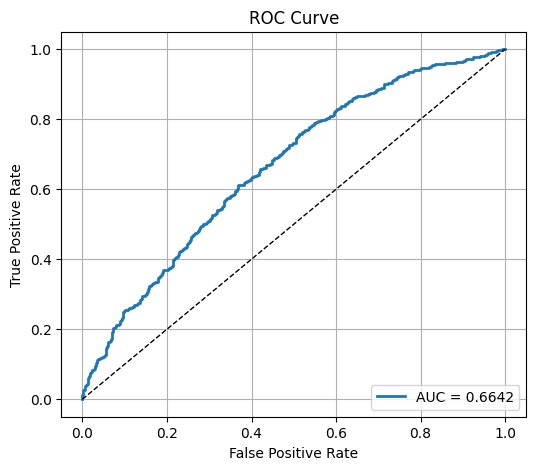

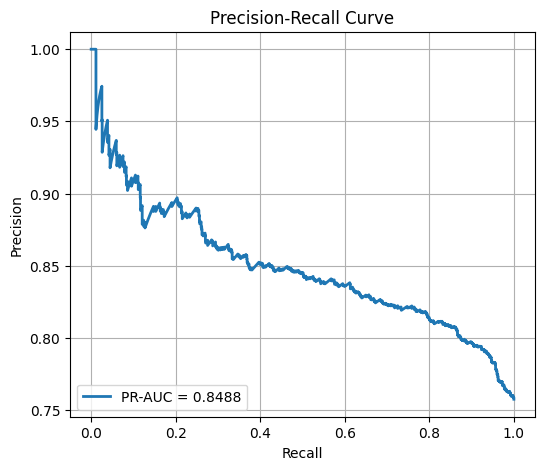

{'roc_auc': 0.6642108627974204,
 'pr_auc': 0.8488234953058778,
 'precision@k': {'1': 1.0,
  '3': 0.9491525423728814,
  '5': 0.9285714285714286,
  '10': 0.8883248730964467},
 'recall@k': {'1': 0.00066711140760507,
  '3': 0.037358238825883926,
  '5': 0.06070713809206137,
  '10': 0.11674449633088725,
  '20': 0.23282188125416944}}

In [11]:
metric_report(y_oot, y_pred, ks=(1, 3, 5, 10, 20))

In [12]:
import pickle

filename = 'lama_10.pkl'

with open(filename, 'wb') as f:
    pickle.dump(automl, f)

print(f"Модель успешно сохранена в файл: {filename}")

Модель успешно сохранена в файл: lama_10.pkl
